In [1]:
# Hard Voting & Soft Voting
# soft voting이 정확도가 더 높아 주로 사용됨

# Scikit learn의 VotingClassifier 클래스
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [2]:
lr_clf = LogisticRegression(solver = 'liblinear')
knn_clf = KNeighborsClassifier(n_neighbors = 8)
vo_clf = VotingClassifier( estimators = [('LR', lr_clf), ('KNN', knn_clf)], voting = 'soft')
# estimators 매개변수에는 분류기의 이름과 해당 분류기 객체를 튜플로 묶어서 입력
# 각 튜플의 첫 번째 요소는 분류기의 이름(문자열로 지정)이고, 두 번째 요소는 실제 분류기 객체

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size = 0.2, random_state = 156)

vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도 : {0:4f}'.format(accuracy_score(y_test,pred)))

# 개별 model들의 학습 / 예측 / 평가
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
  classifier.fit(X_train, y_train)
  pred = classifier.predict(X_test)
  class_name = classifier.__class__.__name__
  print('{0} 정확도 : {1:4f}'.format(class_name, accuracy_score(y_test, pred)))

Voting 분류기 정확도 : 0.956140
LogisticRegression 정확도 : 0.947368
KNeighborsClassifier 정확도 : 0.938596


In [3]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1] > 0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [4]:
def get_human_dataset():
  feature_name_df = pd.read_csv('/content/drive/MyDrive/Kaggle - 파이썬 머신러닝 완벽 가이드/kaggleData/human_activity/features.txt', sep = '\s+', header= None, names = ['column_index', 'column_name'])
  new_feature_name_df = get_new_feature_name_df(feature_name_df)

  # feature 이름 list 생성
  feature_name = new_feature_name_df.iloc[: , 1].values.tolist()
  X_train = pd.read_csv('/content/drive/MyDrive/Kaggle - 파이썬 머신러닝 완벽 가이드/kaggleData/human_activity/train/X_train.txt', sep = '\s+', names = feature_name)
  X_test = pd.read_csv('/content/drive/MyDrive/Kaggle - 파이썬 머신러닝 완벽 가이드/kaggleData/human_activity/test/X_test.txt', sep = '\s+', names = feature_name)
  y_train = pd.read_csv('/content/drive/MyDrive/Kaggle - 파이썬 머신러닝 완벽 가이드/kaggleData/human_activity/train/y_train.txt', sep = '\s+', names = ['action'])
  y_test = pd.read_csv('/content/drive/MyDrive/Kaggle - 파이썬 머신러닝 완벽 가이드/kaggleData/human_activity/test/y_test.txt', sep = '\s+', names = ['action'])

  return X_train, X_test, y_train, y_test

In [5]:
# RandomForest - Bagging의 대표적인 algorithm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

rf_clf = RandomForestClassifier(random_state = 0, max_depth = 8)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도 : {0:4f}'.format(accuracy))

랜덤 포레스트 정확도 : 0.919579


In [6]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth' : [8,16,24], 'min_samples_leaf' : [1,6,12], 'min_samples_split' : [2,8,16]}
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 2, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적의 하이퍼 파라미터 : \n', grid_cv.best_params_)
print('최고 예측 정확도 : {0:4f}'.format(grid_cv.best_score_))

최적의 하이퍼 파라미터 : 
 {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}
최고 예측 정확도 : 0.916485


In [7]:
rf_clf1 = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 6, max_depth = 16, min_samples_split = 2, random_state = 0 )
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도 : {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도 : 0.9260


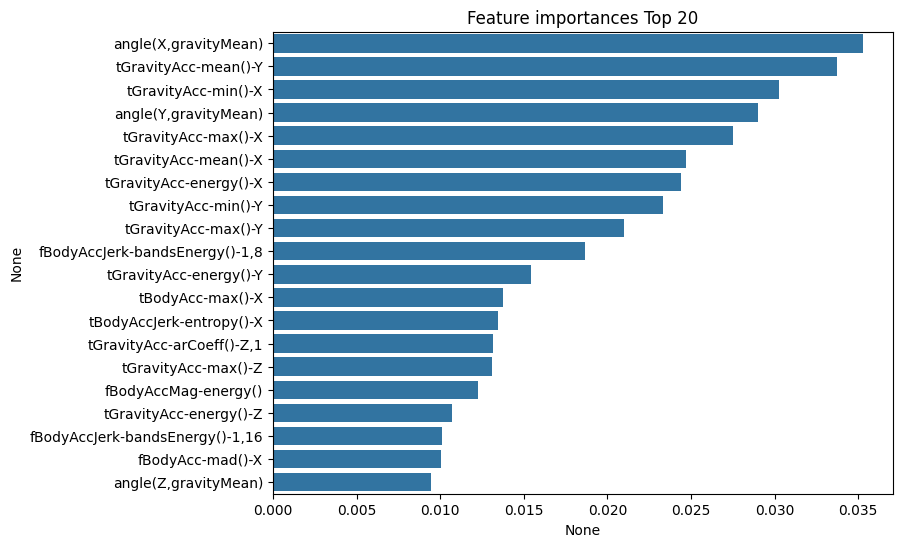

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending = False)[:20]

plt.figure(figsize = (8,6))
plt.title('Feature importances Top 20')
sns.barplot(x = ftr_top20, y = ftr_top20.index)
plt.show()

### **GBM**


In [28]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

start_time = time.time()
gb_clf = GradientBoostingClassifier(random_state = 0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도 : {0:4f}'.format(gb_accuracy))
print('GBM 수행시간 : {0:4f}초'.format(time.time() - start_time))

- (original) 파이썬 래퍼 XGBoost 하이퍼 파라미터


In [12]:
# eXtra Gradient Boost : XGBoost
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target
cancer_df = pd.DataFrame(data = features, columns = dataset.feature_names)
cancer_df['target'] = labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [13]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [14]:
from sklearn.model_selection import train_test_split
X_features = cancer_df.iloc[: , : -1]
y_label = cancer_df.iloc[: ,-1]

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size = 0.2, random_state = 156)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state =156)
print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [15]:
dtr = xgb.DMatrix(data = X_tr, label = y_tr)
dval = xgb.DMatrix(data = X_val, label = y_val)
dtest = xgb.DMatrix(data = X_test, label = y_test)

In [16]:
params = {'max_depth' : 3, 'eta' : 0.05, 'objective' : 'binary:logistic', 'eval_metric' : 'logloss'}
num_rounds = 400

In [17]:
eval_list = [(dtr, 'train'), (dval, 'eval')]
xgb_model = xgb.train(params = params, dtrain = dtr, num_boost_round = num_rounds, early_stopping_rounds = 50, evals = eval_list)

[0]	train-logloss:0.62480	eval-logloss:0.63104
[1]	train-logloss:0.58674	eval-logloss:0.60478
[2]	train-logloss:0.55226	eval-logloss:0.58223
[3]	train-logloss:0.52086	eval-logloss:0.56184
[4]	train-logloss:0.49192	eval-logloss:0.54118
[5]	train-logloss:0.46537	eval-logloss:0.52223
[6]	train-logloss:0.44029	eval-logloss:0.50287
[7]	train-logloss:0.41666	eval-logloss:0.48620
[8]	train-logloss:0.39525	eval-logloss:0.46974
[9]	train-logloss:0.37542	eval-logloss:0.45497
[10]	train-logloss:0.35701	eval-logloss:0.44131
[11]	train-logloss:0.33982	eval-logloss:0.43134
[12]	train-logloss:0.32297	eval-logloss:0.41972
[13]	train-logloss:0.30725	eval-logloss:0.40902
[14]	train-logloss:0.29327	eval-logloss:0.39883
[15]	train-logloss:0.27946	eval-logloss:0.38968
[16]	train-logloss:0.26691	eval-logloss:0.38150
[17]	train-logloss:0.25473	eval-logloss:0.37368
[18]	train-logloss:0.24385	eval-logloss:0.36666
[19]	train-logloss:0.23338	eval-logloss:0.35994
[20]	train-logloss:0.22320	eval-logloss:0.35374
[2

In [18]:
pred_probs = xgb_model.predict(dtest)
print(np.round(pred_probs[:10],3))
preds = [1 if x> 0.5 else 0 for x in pred_probs]
print(preds[:10])

[0.938 0.004 0.75  0.049 0.98  1.    0.999 0.999 0.998 0.001]
[1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def get_clf_eval(y_test, pred = None, pred_proba = None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1 Score : {3:.4f}, AUC : {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [20]:
get_clf_eval (y_test, preds, pred_probs)

오차 행렬
[[35  2]
 [ 2 75]]
정확도 : 0.9649, 정밀도 : 0.9740, 재현율 : 0.9740, F1 Score : 0.9740, AUC : 0.9965


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

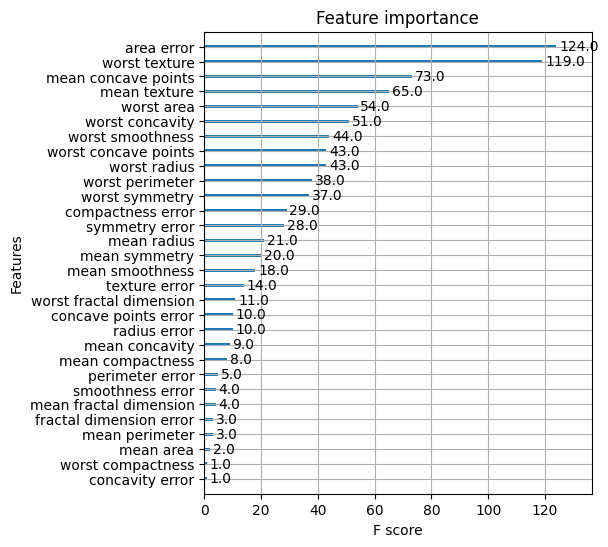

In [21]:
import matplotlib.pyplot as plt
#matplotlib inline
fig, ax = plt.subplots(figsize = (5,6))
plot_importance(xgb_model, ax = ax)

In [22]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.05, max_depth = 3, eval_metric = 'logloss')
xgb_wrapper.fit(X_train, y_train, verbose = True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

## XGBoost에는 라벨이 0부터 시작해야 한다.
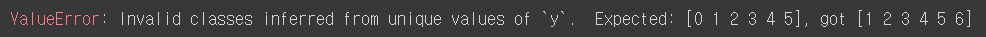

- That happens because the class column has to start from 0 (as required since version 1.3.2). An easy way to solve that is using LabelEncoder from sklearn.preprocssing library.

- 라벨 인코더를 사용하면 문자열 또는 다른 형태의 범주형 데이터를 정수로 변환할 수 있습니다. 이때 정수 라벨은 0부터 시작하여 고유한 범주마다 증가하는 순차적인 값으로 할당됩니다.

- 예를 들어, 클래스가 1, 2, 3, 4로 표현된 경우:

```python
from sklearn.preprocessing import LabelEncoder
# 라벨 인코더 생성 및 적용
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
```
- 이후 y_train_encoded에는 0, 1, 2, 3과 같이 변환된 정수 라벨이 저장됩니다. 이렇게 변환된 클래스 라벨을 사용하여 XGBoost와 같은 알고리즘에 입력으로 제공할 수 있습니다.

```python
import xgboost as xgb

# XGBoost 모델 훈련
model = xgb.XGBClassifier()
model.fit(X_train, y_train_encoded)

```

In [23]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.05, max_depth = 3)
evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds = 50, eval_metric = 'logloss', eval_set = evals, verbose = True)

ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.62480	validation_1-logloss:0.63104
[1]	validation_0-logloss:0.58674	validation_1-logloss:0.60478
[2]	validation_0-logloss:0.55226	validation_1-logloss:0.58223
[3]	validation_0-logloss:0.52086	validation_1-logloss:0.56184
[4]	validation_0-logloss:0.49192	validation_1-logloss:0.54118
[5]	validation_0-logloss:0.46537	validation_1-logloss:0.52223
[6]	validation_0-logloss:0.44029	validation_1-logloss:0.50287
[7]	validation_0-logloss:0.41666	validation_1-logloss:0.48620
[8]	validation_0-logloss:0.39525	validation_1-logloss:0.46974
[9]	validation_0-logloss:0.37542	validation_1-logloss:0.45497
[10]	validation_0-logloss:0.35701	validation_1-logloss:0.44131
[11]	validation_0-logloss:0.33982	validation_1-logloss:0.43134
[12]	validation_0-logloss:0.32297	validation_1-logloss:0.41972
[13]	validation_0-logloss:0.30725	validation_1-logloss:0.40902
[14]	validation_0-logloss:0.29327	validation_1-logloss:0.39883
[15]	validation_0-logloss:0.27946	validation_1-logloss:0.38968
[1

In [24]:
get_clf_eval(y_test, ws50_preds, ws50_pred_proba)

오차 행렬
[[35  2]
 [ 2 75]]
정확도 : 0.9649, 정밀도 : 0.9740, 재현율 : 0.9740, F1 Score : 0.9740, AUC : 0.9961


In [25]:
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds = 10, eval_metric = 'logloss', eval_set = evals, verbose = True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.62480	validation_1-logloss:0.63104
[1]	validation_0-logloss:0.58674	validation_1-logloss:0.60478
[2]	validation_0-logloss:0.55226	validation_1-logloss:0.58223
[3]	validation_0-logloss:0.52086	validation_1-logloss:0.56184
[4]	validation_0-logloss:0.49192	validation_1-logloss:0.54118
[5]	validation_0-logloss:0.46537	validation_1-logloss:0.52223
[6]	validation_0-logloss:0.44029	validation_1-logloss:0.50287
[7]	validation_0-logloss:0.41666	validation_1-logloss:0.48620
[8]	validation_0-logloss:0.39525	validation_1-logloss:0.46974
[9]	validation_0-logloss:0.37542	validation_1-logloss:0.45497
[10]	validation_0-logloss:0.35701	validation_1-logloss:0.44131
[11]	validation_0-logloss:0.33982	validation_1-logloss:0.43134
[12]	validation_0-logloss:0.32297	validation_1-logloss:0.41972
[13]	validation_0-logloss:0.30725	validation_1-logloss:0.40902
[14]	validation_0-logloss:0.29327	validation_1-logloss:0.39883
[15]	validation_0-logloss:0.27946	validation_1-logloss:0.38968
[1

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

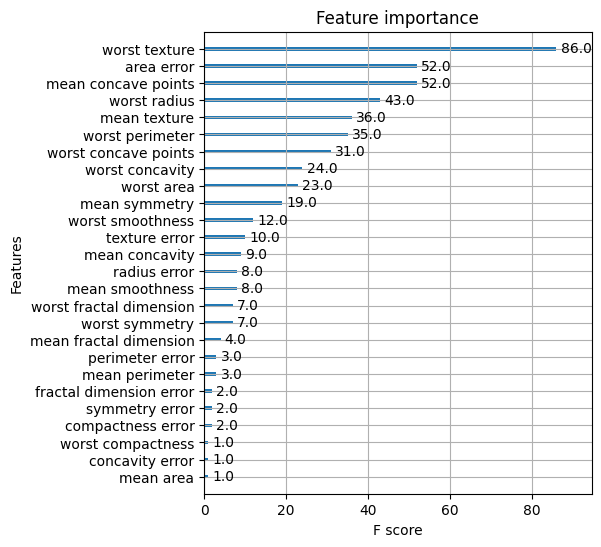

In [26]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (5,6))
plot_importance(xgb_wrapper, ax = ax)